Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# For preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# For other algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# For SHAP (optional)
import shap


Loading Dataset

In [2]:
# 1. Mixed Precision Policy (on Apple Silicon, this can boost performance)
# ---------------------------------------------------------------------
# NOTE: If you see numerical instability, remove or modify this.
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Load the dataset
file_path = '/Users/tejeshwar/Downloads/Quote-Equity-HDFCBANK-EQ-22-04-2024-to-22-04-2025.csv'
data = pd.read_csv(file_path)
data_stock = data.copy()  # Rename to prevent conflict with model summary dictionary

# Strip column names of extra spaces
data.columns = data.columns.str.strip()

# Convert 'Date' to datetime and sort
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')
data = data.sort_values('Date').reset_index(drop=True)

# Convert numerical columns to appropriate types
for col in ['VOLUME', 'VALUE', 'No of trades']:
    data[col] = data[col].str.replace(',', '').astype(float)

# Inspect the data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          249 non-null    datetime64[ns]
 1   series        249 non-null    object        
 2   OPEN          249 non-null    object        
 3   HIGH          249 non-null    object        
 4   LOW           249 non-null    object        
 5   PREV. CLOSE   249 non-null    object        
 6   ltp           249 non-null    object        
 7   close         249 non-null    object        
 8   vwap          249 non-null    object        
 9   52W H         249 non-null    object        
 10  52W L         249 non-null    object        
 11  VOLUME        249 non-null    float64       
 12  VALUE         249 non-null    float64       
 13  No of trades  249 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(10)
memory usage: 27.4+ KB


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2024-04-22,EQ,"1,557.40","1,557.40","1,508.30","1,531.30","1,514.35","1,512.20","1,519.66","1,757.50","1,363.55",21149219.0,3.213972e+10,531868.0
1,2024-04-23,EQ,"1,526.30","1,526.50","1,503.25","1,512.20","1,507.50","1,507.60","1,510.64","1,757.50","1,363.55",13413530.0,2.026300e+10,292429.0
2,2024-04-24,EQ,"1,515.00","1,521.75","1,509.05","1,507.60","1,512.90","1,511.70","1,514.50","1,757.50","1,363.55",11220790.0,1.699386e+10,270693.0
3,2024-04-25,EQ,"1,506.25","1,519.70","1,506.25","1,511.70","1,513.80","1,510.75","1,512.64","1,757.50","1,363.55",17722602.0,2.680799e+10,412279.0
4,2024-04-26,EQ,"1,519.80","1,528.00","1,505.55","1,510.75","1,511.00","1,509.80","1,515.19","1,757.50","1,363.55",12427347.0,1.882979e+10,307546.0


In [4]:
# Ensure all columns have no extra spaces
features = data.columns.str.strip()

# Columns to clean (replace with your actual column names)
features = ['OPEN', 'HIGH', 'LOW', 'close', 'VOLUME']  

# Remove commas and convert to float
for col in features:
    if data[col].dtype == 'object':  # Check if the column contains strings
        data[col] = data[col].str.replace(',', '').astype(float)
    else:  # If already numeric, leave it as is
        data[col] = data[col].astype(float)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort by date and set index
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)


In [5]:
# Assuming `data` is your DataFrame with cleaned column names
data.columns = data.columns.str.strip()  # Clean column names

# Create missing features
data['pct_change'] = data['close'].pct_change()  # Percentage change
data['MA_10'] = data['close'].rolling(window=10).mean()  # 10-day moving average
data['MA_50'] = data['close'].rolling(window=50).mean()  # 50-day moving average

# Drop rows with NaN values
data = data.dropna()

BUILDING LSTM

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['close', 'pct_change', 'MA_10', 'MA_50']])
# Print columns to verify names and types
print(data.columns)

# Ensure accessing DataFrame columns correctly
try:
    scaled_data = scaler.fit_transform(data[['close', 'pct_change', 'MA_10', 'MA_50']])
    print("Scaling successful!")
except Exception as e:
    print("Error in scaling:", e)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predict the 'close' price
    return np.array(x), np.array(y)

seq_length = 10
x, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)




Index(['series', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap',
       '52W H', '52W L', 'VOLUME', 'VALUE', 'No of trades', 'pct_change',
       'MA_10', 'MA_50'],
      dtype='object')
Scaling successful!


In [7]:
# Build the LSTM model
model = Sequential([
    # 1) Bidirectional LSTM layer with 128 units
    Bidirectional(
        LSTM(
            128,
            return_sequences=True,
            # activation='tanh' is default for LSTM; you can set it explicitly if you want
            kernel_regularizer=l2(0.0001)
        ),
        input_shape=(x_train.shape[1], x_train.shape[2])
    ),
    Dropout(0.2),
    
    # 2) Second LSTM layer (64 units, no return_sequences)
    LSTM(
        64,
        kernel_regularizer=l2(0.0001)
    ),
    Dropout(0.2),
    
    # 3) Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Compile the model with an optimized learning rate
initial_lr = 1e-3  # Start with a slightly higher learning rate than 1e-4
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,                # let it train longer if it keeps improving slowly
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                 # reduce LR by half
    patience=10,                # wait 10 epochs of no improvement
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

2025-04-23 09:20:56.401827: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-23 09:20:56.401862: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-23 09:20:56.401865: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-23 09:20:56.402128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 09:20:56.402141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument t

Epoch 1/200


2025-04-23 09:20:57.418369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0782 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0421 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0383 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0346 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0301 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0327 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0284 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0268 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0227 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0

In [8]:
# Evaluate on test set
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Improved LSTM Model - MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.6f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Improved LSTM Model - MSE: 0.002583, MAE: 0.038835, R2: 0.944379


In [9]:
print("Type of features:", type(features))
print("Value of features:", features)
features = len(['close', 'pct_change', 'MA_10', 'MA_50']) 
features = len(data[['close', 'pct_change', 'MA_10', 'MA_50']].columns)


Type of features: <class 'list'>
Value of features: ['OPEN', 'HIGH', 'LOW', 'close', 'VOLUME']


In [10]:
# Assuming 'scaler' and 'model' are already initialized and configured

# Get the last sequence from your data, the input for prediction
last_sequence = scaled_data[-seq_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)  # Reshape for the model

# Predict the next day's closing price
predicted_price_scaled = model.predict(last_sequence)

# Prepare for inverse scaling
full_predicted_features = np.hstack([predicted_price_scaled, np.zeros((predicted_price_scaled.shape[0], features - 1))])

# Inverse transform to get the actual predicted price
predicted_price = scaler.inverse_transform(full_predicted_features)[0, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [11]:
print("Columns in data:", data.columns)


Columns in data: Index(['series', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap',
       '52W H', '52W L', 'VOLUME', 'VALUE', 'No of trades', 'pct_change',
       'MA_10', 'MA_50'],
      dtype='object')


In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Number of features
features = 4  # Adjust this based on your dataset

# Initialize and fit the scaler on your dataset
scaler = MinMaxScaler()
scaler.fit(data[['close', 'pct_change', 'MA_10', 'MA_50']])  # Adjust this line according to your actual features

# Assuming `last_sequence` is prepared correctly
predicted_price_scaled = model.predict(last_sequence)

# Prepare full feature set for inverse transformation
# Here, you adjust assuming the predicted feature is the first one
full_predicted_features = np.hstack([
    predicted_price_scaled,
    np.zeros((predicted_price_scaled.shape[0], features - 1))
])

# Inverse transform to get the actual predicted price
predicted_price = scaler.inverse_transform(full_predicted_features)[0, 0]

print("Actual Open Price for 22/04/2025: ?")
print("Actual Close Price for 22/04/2025: ?")
print("Actual High Price for 22/04/2025: ?")
print("Actual Low Price for 22/04/2025: ?")
print(f"Predicted Price for 22/04/2025: {predicted_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Open Price for 22/04/2025: ?
Actual Close Price for 22/04/2025: ?
Actual High Price for 22/04/2025: ?
Actual Low Price for 22/04/2025: ?
Predicted Price for 22/04/2025: 1936.88


Compare with Other Algorithms

Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Predict and evaluate Random Forest
rf_predictions = rf_model.predict(x_test.reshape(x_test.shape[0], -1))
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)  # Calculating R-squared

print(f'Random Forest MSE: {rf_mse}, MAE: {rf_mae}, R2: {rf_r2}')


Random Forest MSE: 0.0029219230932352944, MAE: 0.04512289218191113, R2: 0.9370785975386228


Lasso Regressor

In [14]:
# Assuming x_train and x_test were originally reshaped as follows:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Now, fit the Lasso model with the reshaped data
# Trying a smaller alpha value
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(x_train_flat, y_train)
lasso_predictions = lasso_model.predict(x_test_flat)

mse_lasso = mean_squared_error(y_test, lasso_predictions)
mae_lasso = mean_absolute_error(y_test, lasso_predictions)
r2_lasso = r2_score(y_test, lasso_predictions)
print(f"Lasso Regression (alpha=0.01) - MSE: {mse_lasso}, MAE: {mae_lasso}, R2: {r2_lasso}")


Lasso Regression (alpha=0.01) - MSE: 0.006575379360403794, MAE: 0.06645691271980746, R2: 0.8584041818109264


Ridge Regression

In [15]:
# Reshape x_train and x_test by flattening the last two dimensions
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("Reshaped x_train:", x_train_flat.shape)
print("Reshaped x_test:", x_test_flat.shape)

# Now, fit the Ridge model with the flattened data
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train_flat, y_train)
ridge_predictions = ridge_model.predict(x_test_flat)

# Calculate performance metrics
mse_ridge = mean_squared_error(y_test, ridge_predictions)
mae_ridge = mean_absolute_error(y_test, ridge_predictions)
r2_ridge = r2_score(y_test, ridge_predictions)
print(f"Ridge Regression - MSE: {mse_ridge}, MAE: {mae_ridge}, R2: {r2_ridge}")




Reshaped x_train: (152, 40)
Reshaped x_test: (38, 40)
Ridge Regression - MSE: 0.0035559471093103367, MAE: 0.045197470542075735, R2: 0.923425370190512


Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocess data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_scaled = scaler.transform(x_test.reshape(x_test.shape[0], -1))

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train_scaled, y_train)

# Predict and evaluate
lr_predictions = lr_model.predict(x_test_scaled)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("Linear Regression Results:")
print(f"Mean Squared Error (MSE): {lr_mse}")
print(f"Mean Absolute Error (MAE): {lr_mae}")
print(f"R-squared (R2): {lr_r2}")


Linear Regression Results:
Mean Squared Error (MSE): 0.004836228150258737
Mean Absolute Error (MAE): 0.05135354310866101
R-squared (R2): 0.8958554869079275


Decision Tree

In [17]:
# Assuming x_train and x_test originally have a shape (n_samples, 10, 4) and you flattened them as:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Verify the reshaping
print("Reshaped x_train:", x_train_flat.shape)
print("Reshaped x_test:", x_test_flat.shape)

# Now fit the Decision Tree model with the reshaped data
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(x_train_flat, y_train)
dt_predictions = dt_model.predict(x_test_flat)

# Calculate performance metrics
mse_dt = mean_squared_error(y_test, dt_predictions)
mae_dt = mean_absolute_error(y_test, dt_predictions)
r2_dt = r2_score(y_test, dt_predictions)
print(f"Decision Tree - MSE: {mse_dt}, MAE: {mae_dt}, R2: {r2_dt}")



Reshaped x_train: (152, 40)
Reshaped x_test: (38, 40)
Decision Tree - MSE: 0.004697410513882842, MAE: 0.05180305131761446, R2: 0.8988448196481926


Support Vector Regressor

In [18]:
from sklearn.svm import SVR

# Train Support Vector Regressor
svr_model = SVR(kernel='rbf')
svr_model.fit(x_train_scaled, y_train)

# Predict and evaluate
svr_predictions = svr_model.predict(x_test_scaled)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print("Support Vector Regressor Results:")
print(f"Mean Squared Error (MSE): {svr_mse}")
print(f"Mean Absolute Error (MAE): {svr_mae}")
print(f"R-squared (R2): {svr_r2}")


Support Vector Regressor Results:
Mean Squared Error (MSE): 0.006468335762813824
Mean Absolute Error (MAE): 0.06491195158368857
R-squared (R2): 0.8607092846729646


Gradient Boosting Regressor

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(x_train_scaled, y_train)

# Predict and evaluate
gbr_predictions = gbr_model.predict(x_test_scaled)
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

print("Gradient Boosting Results:")
print(f"Mean Squared Error (MSE): {gbr_mse}")
print(f"Mean Absolute Error (MAE): {gbr_mae}")
print(f"R-squared (R2): {gbr_r2}")


Gradient Boosting Results:
Mean Squared Error (MSE): 0.0035287084799308826
Mean Absolute Error (MAE): 0.04939857355904329
R-squared (R2): 0.9240119334596305


GRU

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define the refined model
gru = Sequential([
    Input(shape=(10, 4)),

    # First GRU layer with more units
    GRU(128, return_sequences=True),
    Dropout(0.2),

    # Second GRU layer
    GRU(64, return_sequences=False),
    Dropout(0.2),

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# Compile
optimizer = Adam(learning_rate=0.001)
gru.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

# Train
history = gru.fit(
    x_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predict and evaluate
gru_preds = gru.predict(x_test)
y_true = y_test.flatten()
y_pred = gru_preds.flatten()

gru_mse = mean_squared_error(y_true, y_pred)
gru_mae = mean_absolute_error(y_true, y_pred)
gru_r2 = r2_score(y_true, y_pred)

print(f"GRU Refined - MSE: {gru_mse:.6f}, MAE: {gru_mae:.6f}, R2: {gru_r2:.6f}")


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.1434 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0260 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0282 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0225 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0193 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0162 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0133 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0126 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 10/150
4/4 ━━━━━━━━━━

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have these metrics stored in variables

# Create a DataFrame
data = {
    'Model': ['LSTM', 'Ridge', 'Lasso', 'Decision Tree', 'Random Forest', 'GRU', 'Gradient Boosting', 'SVR', 'Linear Regression'],
    'MSE': [mse, mse_ridge, mse_lasso, mse_dt, rf_mse, gru_mse, gbr_mse, svr_mse, lr_mse],
    'MAE': [mae, mae_ridge, mae_lasso, mae_dt, rf_mae, gru_mae, gbr_mae, svr_mae, lr_mae],
    'R2': [r2, r2_ridge, r2_lasso, r2_dt, rf_r2, gru_r2, gbr_r2, svr_r2, lr_r2]
}

df = pd.DataFrame(data)


In [22]:
data_df = pd.DataFrame(data)
print("Corrected DataFrame:")
print(data_df)


Corrected DataFrame:
               Model       MSE       MAE        R2
0               LSTM  0.002583  0.038835  0.944379
1              Ridge  0.003556  0.045197  0.923425
2              Lasso  0.006575  0.066457  0.858404
3      Decision Tree  0.004697  0.051803  0.898845
4      Random Forest  0.002922  0.045123  0.937079
5                GRU  0.003417  0.042681  0.926415
6  Gradient Boosting  0.003529  0.049399  0.924012
7                SVR  0.006468  0.064912  0.860709
8  Linear Regression  0.004836  0.051354  0.895855


In [23]:
print("Summary Statistics:")
print(data_df.describe())


Summary Statistics:
            MSE       MAE        R2
count  9.000000  9.000000  9.000000
mean   0.004287  0.050640  0.907680
std    0.001462  0.009487  0.031482
min    0.002583  0.038835  0.858404
25%    0.003417  0.045123  0.895855
50%    0.003556  0.049399  0.923425
75%    0.004836  0.051803  0.926415
max    0.006575  0.066457  0.944379


In [24]:
sorted_df = data_df.sort_values(by='MSE')
print("Models sorted by MSE:")
print(sorted_df)

Models sorted by MSE:
               Model       MSE       MAE        R2
0               LSTM  0.002583  0.038835  0.944379
4      Random Forest  0.002922  0.045123  0.937079
5                GRU  0.003417  0.042681  0.926415
6  Gradient Boosting  0.003529  0.049399  0.924012
1              Ridge  0.003556  0.045197  0.923425
3      Decision Tree  0.004697  0.051803  0.898845
8  Linear Regression  0.004836  0.051354  0.895855
7                SVR  0.006468  0.064912  0.860709
2              Lasso  0.006575  0.066457  0.858404


In [25]:
import pandas as pd

# Convert dictionary to DataFrame
data_df = pd.DataFrame(data)
print("Converted DataFrame:")
print(data_df.head())

Converted DataFrame:
           Model       MSE       MAE        R2
0           LSTM  0.002583  0.038835  0.944379
1          Ridge  0.003556  0.045197  0.923425
2          Lasso  0.006575  0.066457  0.858404
3  Decision Tree  0.004697  0.051803  0.898845
4  Random Forest  0.002922  0.045123  0.937079


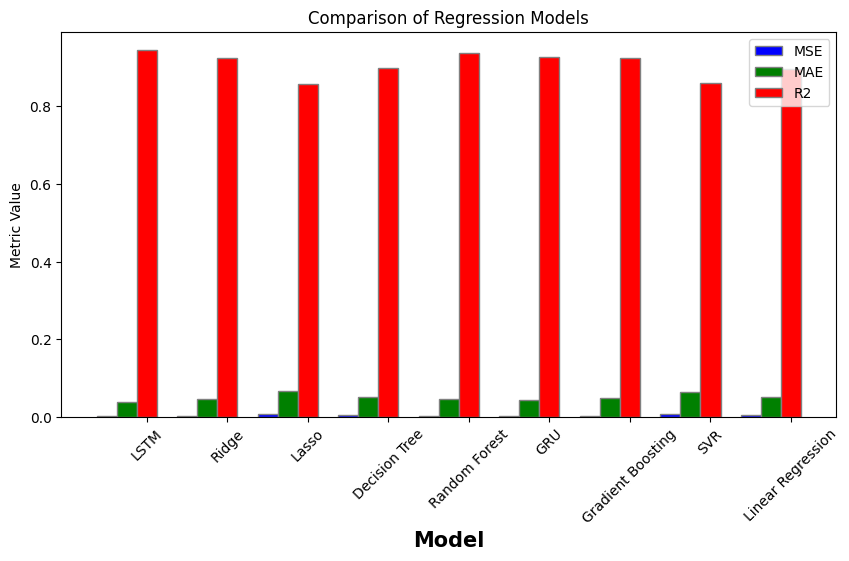

In [26]:
# Set the position of the bars on the x-axis
r = range(len(df))

# Set bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = [x - barWidth for x in r]
r2 = [x for x in r]
r3 = [x + barWidth for x in r]

# Make the plot
plt.figure(figsize=(10, 5))
plt.bar(r1, df['MSE'], color='b', width=barWidth, edgecolor='grey', label='MSE')
plt.bar(r2, df['MAE'], color='g', width=barWidth, edgecolor='grey', label='MAE')
plt.bar(r3, df['R2'], color='r', width=barWidth, edgecolor='grey', label='R2')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df))], df['Model'], rotation=45)  # Rotate labels to 45 degrees
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Models')

# Create legend & Show graphic
plt.legend()
plt.show()


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.layers import Multiply, Lambda, Add
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.python.client import device_lib

# === Enable GPU Memory Growth ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ Could not set memory growth: {e}")

# === Define time and feature dimensions ===
num_timesteps = x_train.shape[1]
num_features = x_train.shape[2]

# === Model builder ===
def build_attention_model(hp):
    conv_filters = hp.Choice("conv_filters", [64, 128], default=64)
    dropout_rate = hp.Float("dropout_rate", 0.1, 0.4, step=0.1, default=0.2)
    lstm_units = hp.Choice("lstm_units", [32, 64, 96], default=64)
    dense_units = hp.Choice("dense_units", [32, 64, 128], default=64)
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)

    inputs = tf.keras.Input(shape=(num_timesteps, num_features))
    
    conv_output = layers.Conv1D(filters=conv_filters, kernel_size=3, padding='same', activation='relu')(inputs)
    conv_output = layers.BatchNormalization()(conv_output)
    conv_output = layers.Dropout(dropout_rate)(conv_output)

    x = layers.LSTM(lstm_units, return_sequences=True)(conv_output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.LSTM(lstm_units, return_sequences=False)(x)
    x = layers.Dropout(dropout_rate)(x)

    attention_score = layers.Dense(1, activation='tanh')(conv_output)
    attention_weights = layers.Softmax(axis=1)(attention_score)
    context_vector = Multiply()([attention_weights, conv_output])
    context_vector = Lambda(lambda t: K.sum(t, axis=1))(context_vector)

    x_proj = layers.Dense(conv_filters)(x)  # Align with attention vector shape
    combined = Add()([x_proj, context_vector])

    x = layers.Dense(dense_units, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# === Tuner ===
tuner = kt.Hyperband(
    build_attention_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_dir',
    project_name='stock_attention_v2'
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-4, verbose=1)

# === Device Info ===
print("\n🔍 Devices TensorFlow Can See:")
print(device_lib.list_local_devices())
tf.debugging.set_log_device_placement(True)

# === Run Hyperparameter Search ===
tuner.search(
    x_train, y_train,
    epochs=40,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# === Best Model and Hyperparameters ===
best_hps = tuner.get_best_hyperparameters(1)[0]
print("\n--- Best Hyperparameters Found ---")
print(f"Conv Filters: {best_hps.get('conv_filters')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# === Build and Train Final Model ===
model = tuner.hypermodel.build(best_hps)
model.summary()  # Optional: show model structure

history = model.fit(
    x_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# === Evaluation ===
attention_predictions = model.predict(x_test)
attention_mse = mean_squared_error(y_test, attention_predictions)
attention_mae = mean_absolute_error(y_test, attention_predictions)
attention_r2 = r2_score(y_test, attention_predictions)

print("\n📊 Final Attention Model Performance:")
print(f"MSE : {attention_mse:.6f}")
print(f"MAE : {attention_mae:.6f}")
print(f"R²  : {attention_r2:.6f}")

# === Save Results (Optional) ===
attention_metrics = {
    'Model': 'Attention',
    'MSE': attention_mse,
    'MAE': attention_mae,
    'R2': attention_r2
}

# === Optional Save ===
model.save("attention_model_v2.h5")
print("📁 Model saved as attention_model_v2.h5")


⚠️ Could not set memory growth: Physical devices cannot be modified after being initialized
Reloading Tuner from hyperband_dir/stock_attention_v2/tuner0.json

🔍 Devices TensorFlow Can See:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4364789369977351267
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 13538530289104438619
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]

--- Best Hyperparameters Found ---
Conv Filters: 128
LSTM Units: 96
Dense Units: 32
Dropout Rate: 0.1
Learning Rate: 0.007880010037605347


2025-04-23 09:27:48.570299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 09:27:48.570378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 10, 4)     │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 128)   │      1,664 │ cast_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 96)    │     86,400 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 10, 96)    │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 1)     │        129 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 96)        │     74,112 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 10, 1)     │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 96)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 10, 128)   │          0 │ softmax_1[0][0],  │
│ (Multiply)          │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     12,416 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      4,128 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 179,522 (701.26 KB)

 Trainable params: 179,202 (700.01 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - loss: 2.0078 - val_loss: 0.0302 - learning_rate: 0.0079
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2471 - val_loss: 0.3125 - learning_rate: 0.0079
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1594 - val_loss: 0.0761 - learning_rate: 0.0079
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1743 - val_loss: 0.0676 - learning_rate: 0.0079
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1741 - val_loss: 0.0269 - learning_rate: 0.0079
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1866 - val_loss: 0.1679 - learning_rate: 0.0079
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1549 - val_loss: 0.1563 - learning_rate: 0.0079
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1028 - val_loss: 0.2502 - learning_rate: 0.0079
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1079
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.003940004855394


📊 Final Attention Model Performance:
MSE : 0.026880
MAE : 0.130515
R²  : 0.421158
📁 Model saved as attention_model_v2.h5


In [28]:
import tensorflow as tf
print("Available devices:", tf.config.list_physical_devices())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# Fix column names: strip spaces and make lowercase
data_stock.columns = data_stock.columns.str.strip().str.lower()


In [30]:
# Strip commas and convert prices to float
for col in ['open', 'high', 'low', 'close', 'volume', 'value']:
    data_stock[col] = data_stock[col].astype(str).str.replace(',', '').astype(float)


In [31]:
data_stock['pct_change'] = data_stock['close'].pct_change()
data_stock['ma_10'] = data_stock['close'].rolling(window=10).mean()
data_stock['ma_50'] = data_stock['close'].rolling(window=50).mean()
data_stock.dropna(inplace=True)


In [32]:
# Determine number of features from the scaled data
num_features = scaled_data.shape[1]  # e.g., 4 if using ['close', 'pct_change', 'MA_10', 'MA_50']

# Prepare the last sequence for prediction
last_sequence = scaled_data[-seq_length:]  # shape: (10, 4)
last_sequence = np.expand_dims(last_sequence, axis=0)  # shape: (1, 10, 4)

# Predict the next day's scaled 'close' price
next_day_scaled_pred = model.predict(last_sequence)

# Construct full feature array for inverse scaling (pad with zeros)
full_predicted_features = np.hstack([
    next_day_scaled_pred,                      # predicted 'close'
    np.zeros((1, num_features - 1))            # dummy features
])

# Clean column names
data_stock.columns = data_stock.columns.str.strip().str.lower()

# Convert price and volume fields to float
for col in ['open', 'high', 'low', 'close', 'volume', 'value']:
    data_stock[col] = data_stock[col].astype(str).str.replace(',', '').astype(float)

# Now add features
data_stock['pct_change'] = data_stock['close'].pct_change()
data_stock['ma_10'] = data_stock['close'].rolling(window=10).mean()
data_stock['ma_50'] = data_stock['close'].rolling(window=50).mean()
data_stock.dropna(inplace=True)

# Fit scaler
prediction_scaler = MinMaxScaler()
prediction_scaler.fit(data_stock[['close', 'pct_change', 'ma_10', 'ma_50']])



# ✅ Use this scaler to inverse transform
predicted_price = prediction_scaler.inverse_transform(full_predicted_features)[0, 0]

# Replace with actual next-day known values if available
actual_prices = {
    "Open": 1656.505,
    "Close": 1643.05,
    "High": 1662.70,
    "Low": 1636.30
}

# Print the result
print("\n----- Stock Price Comparison -----")
for k, v in actual_prices.items():
    print(f"Actual {k} Price: {v}")
print(f"Predicted Close Price (Hybrid Model) for next day: {predicted_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

----- Stock Price Comparison -----
Actual Open Price: 1656.505
Actual Close Price: 1643.05
Actual High Price: 1662.7
Actual Low Price: 1636.3
Predicted Close Price (Hybrid Model) for next day: 1775.92


In [33]:
print("data_stock columns:", data_stock.columns.tolist())


data_stock columns: ['date', 'series', 'open', 'high', 'low', 'prev. close', 'ltp', 'close', 'vwap', '52w h', '52w l', 'volume', 'value', 'no of trades', 'pct_change', 'ma_10', 'ma_50']


Analyze Parameters using SHAP

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   5%|▌         | 2/38 [00:00<?, ?it/s]

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  11%|█         | 4/38 [00:22<01:57,  3.45s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  13%|█▎        | 5/38 [00:28<02:31,  4.59s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  16%|█▌        | 6/38 [00:35<02:46,  5.20s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 7/38 [00:41<02:51,  5.53s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 8/38 [00:47<02:52,  5.75s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▎       | 9/38 [00:53<02:50,  5.87s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  26%|██▋       | 10/38 [00:59<02:46,  5.96s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  29%|██▉       | 11/38 [01:05<02:42,  6.01s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 12/38 [01:12<02:37,  6.06s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  34%|███▍      | 13/38 [01:18<02:32,  6.09s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 14/38 [01:24<02:26,  6.10s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  39%|███▉      | 15/38 [01:30<02:22,  6.19s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  42%|████▏     | 16/38 [01:36<02:15,  6.17s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  45%|████▍     | 17/38 [01:43<02:09,  6.18s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  47%|████▋     | 18/38 [01:49<02:03,  6.17s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  50%|█████     | 19/38 [01:55<01:57,  6.18s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  53%|█████▎    | 20/38 [02:01<01:51,  6.18s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  55%|█████▌    | 21/38 [02:07<01:45,  6.22s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  58%|█████▊    | 22/38 [02:14<01:41,  6.34s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  61%|██████    | 23/38 [02:20<01:33,  6.23s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


PermutationExplainer explainer:  63%|██████▎   | 24/38 [02:27<01:31,  6.56s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  66%|██████▌   | 25/38 [02:34<01:25,  6.61s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 26/38 [02:40<01:17,  6.48s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  71%|███████   | 27/38 [02:46<01:10,  6.37s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  74%|███████▎  | 28/38 [02:53<01:03,  6.31s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▋  | 29/38 [02:59<00:56,  6.25s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


PermutationExplainer explainer:  79%|███████▉  | 30/38 [03:05<00:49,  6.22s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  82%|████████▏ | 31/38 [03:11<00:43,  6.25s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


PermutationExplainer explainer:  84%|████████▍ | 32/38 [03:18<00:38,  6.48s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


PermutationExplainer explainer:  87%|████████▋ | 33/38 [03:25<00:32,  6.46s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  89%|████████▉ | 34/38 [03:32<00:27,  6.81s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 35/38 [03:38<00:19,  6.51s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▍| 36/38 [03:44<00:12,  6.32s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 37/38 [03:50<00:06,  6.16s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 100%|██████████| 38/38 [03:55<00:00,  6.05s/it]

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 39it [04:01,  6.53s/it]                        


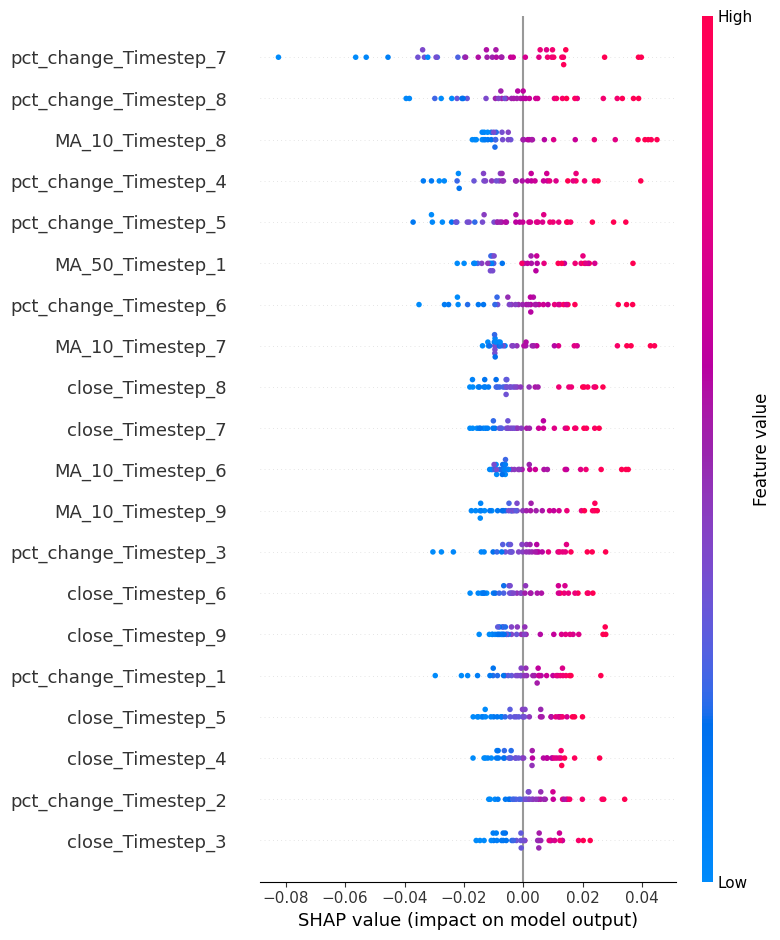

In [34]:
import shap
import pandas as pd
import numpy as np

# Define a wrapper function to ensure SHAP respects the 3D input
class LSTMWrapper:
    def __init__(self, model):
        self.model = model
    
    def __call__(self, data):
        # Reshape data back to 3D for the model
        num_samples = data.shape[0]
        timesteps = 10  # Replace with the actual number of timesteps in your data
        num_features = data.shape[1] // timesteps
        reshaped_data = data.values.reshape(num_samples, timesteps, num_features)
        return self.model.predict(reshaped_data)

# Flatten x_train and x_test for SHAP
num_samples, timesteps, num_features = x_train.shape
x_train_flat = x_train.reshape(num_samples, timesteps * num_features)
x_test_flat = x_test.reshape(x_test.shape[0], timesteps * num_features)

# Map dataset features to meaningful names
feature_mapping = {
    0: 'close',
    1: 'pct_change',
    2: 'MA_10',
    3: 'MA_50'
}

# Generate feature names for timesteps and features
feature_names = [
    f"{feature_mapping[i]}_Timestep_{t}" 
    for t in range(timesteps) 
    for i in range(num_features)
]

# Convert flattened arrays to DataFrames
x_train_flat_df = pd.DataFrame(x_train_flat, columns=feature_names)
x_test_flat_df = pd.DataFrame(x_test_flat, columns=feature_names)

# Wrap the LSTM model
wrapped_model = LSTMWrapper(model)

# Create SHAP explainer with the wrapped model
masker = shap.maskers.Independent(x_train_flat_df)
explainer = shap.Explainer(wrapped_model, masker)

# Compute SHAP values
shap_values = explainer(x_test_flat_df)

# Generate SHAP summary plot
shap.summary_plot(shap_values, x_test_flat_df)
